In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# E2E ML on GCP: MLOps stage 1 : data management

<table align="left">
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/ml_ops/stage1/mlops_data_management.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/ai/platform/notebooks/deploy-notebook?download_url=https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/ml_ops/stage1/mlops_data_management.ipynb">
      Open in Google Cloud Notebooks
    </a>
  </td>
</table>
<br/><br/><br/>

## Overview


This tutorial demonstrates how to use Vertex AI for E2E MLOps on Google Cloud in production. This tutorial covers stage 1 : data management.

### Dataset

The dataset used for this tutorial is the [Chicago Taxi](https://www.kaggle.com/chicago/chicago-taxi-trips-bq). The version of the dataset you will use in this tutorial is stored in a public BigQuery table. The trained model predicts whether someone would leave a tip for a taxi fare.

### Objective

In this tutorial, you create a MLOps stage 1: data management process.

This tutorial uses the following Vertex AI and Data Analytics services:

- `Vertex AI Datasets`
- `BigQuery`
- `Dataflow`

The steps performed include:

- Explore and visualize the data.
- Create a Vertex AI `Dataset` resource from `BigQuery` table -- for AutoML training.
- Extract a copy of the dataset to a CSV file in Cloud Storage.
- Create a Vertex AI `Dataset` resource from CSV files -- alternative for AutoML training.
- Read a sample of the `BigQuery` dataset into a dataframe.
- Generate statistics and data schema using TensorFlow Data Validation from the samples in the dataframe.
- Generate a TFRecord feature specification using TensorFlow Data Validation from the data schema.
- Preprocess a portion of the BigQuery data using `Dataflow` -- for custom training.

### Recommendations

When doing E2E MLOps on Google Cloud for data management, the following best practices with structured (tabular) data are recommended:

 - For large amounts of data, use BigQuery table. Otherwise, use a CSV file stored in Cloud Storage.
 - When storing a large amount of data in CSV file, shard the data at 10,000 rows per shard.
 - Create a managed dataset with Vertex AI `TabularDataset`.
 - Preprocess the data with `Dataflow`

## Installations

Install *one time* the packages for executing the MLOps notebooks.

In [ ]:
ONCE_ONLY = True
if ONCE_ONLY:
    ! pip3 install -U tensorflow==2.5 $USER_FLAG
    ! pip3 install -U tensorflow-data-validation==1.2 $USER_FLAG
    ! pip3 install -U tensorflow-transform==1.2 $USER_FLAG
    ! pip3 install -U tensorflow-io==0.18 $USER_FLAG
    ! pip3 install --upgrade google-cloud-aiplatform[tensorboard] $USER_FLAG
    ! pip3 install --upgrade google-cloud-pipeline-components $USER_FLAG
    ! pip3 install --upgrade google-cloud-bigquery $USER_FLAG
    ! pip3 install --upgrade google-cloud-logging $USER_FLAG
    ! pip3 install --upgrade apache-beam[gcp] $USER_FLAG
    ! pip3 install --upgrade pyarrow $USER_FLAG
    ! pip3 install --upgrade cloudml-hypertune $USER_FLAG
    ! pip3 install --upgrade kfp $USER_FLAG

### Restart the kernel

Once you've installed the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI, BigQuery, Compute Engine and Cloud Storage APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,bigquery,compute_component,storage_component).

1. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [1]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: andy-1234-221921


In [3]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [4]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append the timestamp onto the name of resources you create in this tutorial.

In [5]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**If you are using Google Cloud Notebooks**, your environment is already authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

In the Cloud Console, go to the [Create service account key](https://console.cloud.google.com/apis/credentials/serviceaccountkey) page.

1. **Click Create service account**.

2. In the **Service account name** field, enter a name, and click **Create**.

3. In the **Grant this service account access to project** section, click the Role drop-down list. Type "Vertex AI" into the filter box, and select **Vertex AI Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

4. Click Create. A JSON file that contains your key downloads to your local environment.

5. Enter the path to your service account key as the GOOGLE_APPLICATION_CREDENTIALS variable in the cell below and run the cell.

In [ ]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# If on Google Cloud Notebooks, then don't execute this code
if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a custom training job using the Vertex SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. Vertex AI runs
the code from this package. In this tutorial, Vertex AI also saves the
trained model that results from your job in the same bucket. You can then
create an `Endpoint` resource based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

In [6]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [7]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "aip-" + TIMESTAMP
    BUCKET_URI = "gs://" + BUCKET_NAME

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [8]:
! gsutil mb -l $REGION $BUCKET_URI

Creating gs://andy-1234-221921aip-20220426161156/...


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [9]:
! gsutil ls -al $BUCKET_URI

### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries and define constants

In [10]:
import google.cloud.aiplatform as aip

#### Import BigQuery

Import the BigQuery package into your Python environment.

In [11]:
from google.cloud import bigquery

#### Import Apache Beam

Import the Apache Beam package into your Python environment.

In [12]:
import apache_beam as beam

#### Import TensorFlow

Import the TensorFlow package into your Python environment.

In [13]:
import tensorflow as tf

2022-04-26 16:12:05.715835: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


#### Import TensorFlow Data Validation

Import the TensorFlow Data Validation (TFDV) package into your Python environment.

In [14]:
import tensorflow_data_validation as tfdv

#### Import TensorFlow Transform

Import the TensorFlow Transform (TFT) package into your Python environment.

In [15]:
import tensorflow_transform as tft

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [16]:
aip.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

### Create BigQuery client

Create the BigQuery client.

In [17]:
bqclient = bigquery.Client()

## Datasets

Next, you look at options for creating managed datasets:

* `BigQuery`: Create a Vertex `TabularDataset` resource.
* `CSV`: Create a Vertex `TabularDataset` resource.
* `TFRecords`: Self-manage the dataset on Cloud Storage storage.

#### Location of BigQuery training data.

Now set the variable `IMPORT_FILE` to the location of the data table in BigQuery.

In [18]:
IMPORT_FILE = "bq://bigquery-public-data.chicago_taxi_trips.taxi_trips"
BQ_TABLE = "bigquery-public-data.chicago_taxi_trips.taxi_trips"

### Explore BigQuery dataset

Explore the contents of the BigQuery table:

- Get all examples from 2015
- Sort by the day of the week
- Count the number of examples for each day of the week

In [19]:
query = """SELECT
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek,
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2015
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek"""

_ = bqclient.query(query)
rows = _.result()
dataframe = rows.to_dataframe()
print(dataframe.head(7))

  trip_dayofweek trip_dayname  trip_count
0              1       Sunday     4141154
1              2       Monday     4105900
2              3      Tuesday     4378805
3              4    Wednesday     4542810
4              5     Thursday     4918190
5              6       Friday     5289830
6              7     Saturday     5009186


<AxesSubplot:xlabel='trip_dayname'>

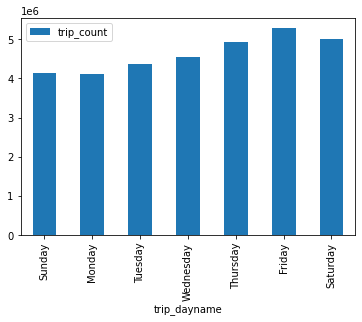

In [20]:
dataframe.plot(kind="bar", x="trip_dayname", y="trip_count")

### Make a private copy of subset of BigQuery table

Next, you make a private copy of the BigQuery table:
- Select a subset of columns
- Select a subset of rows (LIMIT)
- Set conditions (WHERE)
- Do feature engineering on geolocation coords.
- Pre-split the dataset

In [21]:
BQ_DATASET = BQ_TABLE.split(".")[1]
BQ_TABLE_COPY = f"{PROJECT_ID}.{BQ_DATASET}.taxi_trips"
LIMIT = 300000
YEAR = 2020

query = f"""
CREATE OR REPLACE TABLE `{BQ_TABLE_COPY}`
AS (
    WITH
      taxitrips AS (
      SELECT
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `{BQ_TABLE}`
      WHERE pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = {YEAR}
    )

    SELECT
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      CAST(trip_seconds AS FLOAT64) as trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude),
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      CONCAT(
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickup_longitude,
              pickup_latitude), 0.1)),
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropoff_longitude,
              dropoff_latitude), 0.1))
      ) AS loc_cross,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
    FROM
      taxitrips
    LIMIT {LIMIT}
)
"""

response = bqclient.query(query)
_ = response.result()

BQ_TABLE = BQ_TABLE_COPY
IMPORT_FILE = f"bq://{BQ_TABLE_COPY}"

### Create the Dataset

#### BigQuery input data

Next, create the `Dataset` resource using the `create` method for the `TabularDataset` class, which takes the following parameters:

- `display_name`: The human readable name for the `Dataset` resource.
- `bq_source`: Import data items from a BigQuery table into the `Dataset` resource.
- `labels`: User defined metadata. In this example, you store the location of the Cloud Storage bucket containing the user defined data.

Learn more about [TabularDataset from BigQuery table](https://cloud.google.com/vertex-ai/docs/datasets/create-dataset-api#aiplatform_create_dataset_tabular_bigquery_sample-python).

In [22]:
dataset = aip.TabularDataset.create(
    display_name="Chicago Taxi" + "_" + TIMESTAMP,
    bq_source=[IMPORT_FILE],
    labels={"user_metadata": BUCKET_NAME},
)

label_column = "tip_bin"

print(dataset.resource_name)

Creating TabularDataset
Create TabularDataset backing LRO: projects/759209241365/locations/us-central1/datasets/5683942951974076416/operations/881287775440076800
TabularDataset created. Resource name: projects/759209241365/locations/us-central1/datasets/5683942951974076416
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/759209241365/locations/us-central1/datasets/5683942951974076416')
projects/759209241365/locations/us-central1/datasets/5683942951974076416


### Read the BigQuery dataset into a pandas dataframe

Next, you read a sample of the dataset into a pandas dataframe using BigQuery `list_rows()` and `to_dataframe()` method, as follows:

- `list_rows()`: Performs a query on the specified table and returns a row iterator to the query results. Optionally specify:
 - `selected_fields`: Subset of fields (columns) to return.
 - `max_results`: The maximum number of rows to return. Same as SQL LIMIT command.


- `rows.to_dataframe()`: Invokes the row iterator and reads in the data into a pandas dataframe.

Learn more about [Loading BigQuery table into a dataframe](https://cloud.google.com/bigquery/docs/bigquery-storage-python-pandas)

In [23]:
# Download a table.
table = bigquery.TableReference.from_string(BQ_TABLE)

rows = bqclient.list_rows(table, max_results=300000)

dataframe = rows.to_dataframe()
print(dataframe.head())

   trip_month  trip_day  trip_day_of_week  trip_hour  trip_seconds  \
0           4         1                 4         12         378.0   
1           2         1                 7          4         908.0   
2           6         1                 2         21          37.0   
3           5         1                 6         20         538.0   
4           5         1                 6         15         248.0   

   trip_miles payment_type      pickup_grid     dropoff_grid    euclidean  \
0        1.44         Cash  POINT(-87.7 42)  POINT(-87.7 42)  2406.040979   
1        3.76         Cash  POINT(-87.7 42)  POINT(-87.7 42)  5937.478839   
2        0.02         Cash  POINT(-87.7 42)  POINT(-87.7 42)     0.000000   
3        1.29         Cash  POINT(-87.7 42)  POINT(-87.7 42)     0.000000   
4        0.47         Cash  POINT(-87.7 42)  POINT(-87.7 42)     0.000000   

                        loc_cross  tip_bin  
0  POINT(-87.7 42)POINT(-87.7 42)        0  
1  POINT(-87.7 42)POINT(-8

###  Generate dataset statistics

#### Dataframe input data

Generate statistics on the dataset with the TensorFlow Data Validation (TFDV) package. Use the `generate_statistics_from_dataframe()` method, with the following parameters:

- `dataframe`: The dataset in an in-memory pandas dataframe.
- `stats_options`: The selected statistics options:
  - `label_feature`: The column which is the label to predict.
  - `sample_rate`: The sampling rate. If specified, statistics is computed over the sample.
  - `num_top_values`: number of most frequent feature values to keep for string features.

Learn about [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started).

In [24]:
stats = tfdv.generate_statistics_from_dataframe(
    dataframe=dataframe,
    stats_options=tfdv.StatsOptions(
        label_feature="tip_bin", sample_rate=1, num_top_values=50
    ),
)

print(stats)

datasets {
  num_examples: 300000
  features {
    num_stats {
      common_stats {
        num_non_missing: 300000
        min_num_values: 1
        max_num_values: 1
        avg_num_values: 1.0
        num_values_histogram {
          buckets {
            low_value: 1.0
            high_value: 1.0
            sample_count: 30000.0
          }
          buckets {
            low_value: 1.0
            high_value: 1.0
            sample_count: 30000.0
          }
          buckets {
            low_value: 1.0
            high_value: 1.0
            sample_count: 30000.0
          }
          buckets {
            low_value: 1.0
            high_value: 1.0
            sample_count: 30000.0
          }
          buckets {
            low_value: 1.0
            high_value: 1.0
            sample_count: 30000.0
          }
          buckets {
            low_value: 1.0
            high_value: 1.0
            sample_count: 30000.0
          }
          buckets {
            low_value: 1.0


### Visualize dataset statistics

A visualization of the dataset statistics can be displayed using the TFDV `visualize_statistics()` method.

In [25]:
tfdv.visualize_statistics(stats)

### Extract feature grouping from statistics

Next, you extract from the statistics the feature names and data types, from which you group features into:

- numeric: float
- categorical: string, int

In [26]:
NUMERIC_FEATURES = []
CATEGORICAL_FEATURES = []
for _ in range(len(stats.datasets[0].features)):
    if stats.datasets[0].features[_].path.step[0] == label_column:
        continue
    if stats.datasets[0].features[_].type == 0:  # int
        CATEGORICAL_FEATURES.append(stats.datasets[0].features[_].path.step[0])
    elif stats.datasets[0].features[_].type == 1:  # float
        NUMERIC_FEATURES.append(stats.datasets[0].features[_].path.step[0])
    elif stats.datasets[0].features[_].type == 2:  # string
        CATEGORICAL_FEATURES.append(stats.datasets[0].features[_].path.step[0])

### Retain feature column information

Next, you retain information on the feature columns in the dataset. In this example, you add this user-defined metadata as a JSON file to the Cloud Storage bucket you associated with the dataset.

In [27]:
import json

metadata = {
    "label_column": label_column,
    "numeric_features": NUMERIC_FEATURES,
    "categorical_features": CATEGORICAL_FEATURES,
}
with tf.io.gfile.GFile(
    "gs://" + dataset.labels["user_metadata"] + "/metadata.jsonl", "w"
) as f:
    json.dump(metadata, f)

#### Retain statistics for the dataset

Next, you write the statistics for the dataset to the dataset's Cloud Storage bucket, and retain the Cloud Storage location of the statistics file. In this example, you add it to the user-defined metadata for this dataset, which is stored in the dataset's Cloud Storage bucket.

In [28]:
STATISTICS_SCHEMA = BUCKET_URI + "/statistics.jsonl"

tfdv.write_stats_text(stats, BUCKET_URI + "/statistics.jsonl")

with tf.io.gfile.GFile(
    "gs://" + dataset.labels["user_metadata"] + "/metadata.jsonl", "r"
) as f:
    metadata = json.load(f)

metadata["statistics"] = STATISTICS_SCHEMA
with tf.io.gfile.GFile(
    "gs://" + dataset.labels["user_metadata"] + "/metadata.jsonl", "w"
) as f:
    json.dump(metadata, f)

! gsutil cat $BUCKET_URI/metadata.jsonl

{"label_column": "tip_bin", "numeric_features": ["trip_seconds", "trip_miles", "euclidean"], "categorical_features": ["trip_month", "trip_day", "trip_day_of_week", "trip_hour", "payment_type", "pickup_grid", "dropoff_grid", "loc_cross"], "statistics": "gs://andy-1234-221921aip-20220426161156/statistics.jsonl"}

###  Generate the raw data schema

Generate the data schema on the dataset with the TensorFlow Data Validation (TFDV) package. Use the `infer_schema()` method, with the following parameters:

- `statistics`: The statistics generated by TFDV.

In [29]:
schema = tfdv.infer_schema(statistics=stats)
print(schema)

feature {
  name: "trip_month"
  type: INT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "trip_day"
  type: INT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "trip_day_of_week"
  type: INT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "trip_hour"
  type: INT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "trip_seconds"
  type: FLOAT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "trip_miles"
  type: FLOAT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "payment_type"
  type: BYTES
  domain: "payment_type"
  presence {
    min_fraction: 1.0
    min_count:

#### Save schema for the dataset to Cloud Storage

Next, you write the schema for the dataset to the dataset's Cloud Storage bucket.

In [30]:
SCHEMA_LOCATION = BUCKET_URI + "/schema.txt"

# When running Apache Beam directly (file is directly accessed)
tfdv.write_schema_text(output_path=SCHEMA_LOCATION, schema=schema)
# When running with Dataflow (file is uploaded to worker pool)
tfdv.write_schema_text(output_path="schema.txt", schema=schema)

#### Retain schema for the dataset

Next, you retain the Cloud Storage location of the schema file. In this example, you add it to the user-defined metadata for this dataset, which is stored in the dataset's Cloud Storage bucket.

In [31]:
with tf.io.gfile.GFile(
    "gs://" + dataset.labels["user_metadata"] + "/metadata.jsonl", "r"
) as f:
    metadata = json.load(f)
metadata["schema"] = SCHEMA_LOCATION

with tf.io.gfile.GFile(
    "gs://" + dataset.labels["user_metadata"] + "/metadata.jsonl", "w"
) as f:
    json.dump(metadata, f)

! gsutil cat $BUCKET_URI/metadata.jsonl

{"label_column": "tip_bin", "numeric_features": ["trip_seconds", "trip_miles", "euclidean"], "categorical_features": ["trip_month", "trip_day", "trip_day_of_week", "trip_hour", "payment_type", "pickup_grid", "dropoff_grid", "loc_cross"], "statistics": "gs://andy-1234-221921aip-20220426161156/statistics.jsonl", "schema": "gs://andy-1234-221921aip-20220426161156/schema.txt"}

### Generate the feature specification

Generate the feature specification, compatible with TFRecords, on the dataset with the TensorFlow Transform (TFT) package. Use the `schema_as_feature_spec()` method, with the following parameters:

- `schema`: The data schema generated by TFDV.

In [32]:
feature_spec = tft.tf_metadata.schema_utils.schema_as_feature_spec(schema).feature_spec

print(feature_spec)

{'trip_month': FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None), 'trip_day': FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None), 'trip_day_of_week': FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None), 'trip_hour': FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None), 'trip_seconds': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'trip_miles': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'payment_type': FixedLenFeature(shape=[1], dtype=tf.string, default_value=None), 'pickup_grid': FixedLenFeature(shape=[1], dtype=tf.string, default_value=None), 'dropoff_grid': FixedLenFeature(shape=[1], dtype=tf.string, default_value=None), 'euclidean': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'loc_cross': FixedLenFeature(shape=[1], dtype=tf.string, default_value=None), 'tip_bin': FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None)}


#### Prepare package requirements for Dataflow job.

Before you can run a Dataflow job, you need to specify the package requirements for the worker pool that will execute the job.

In [33]:
%%writefile setup.py
import setuptools

REQUIRED_PACKAGES = [
    "google-cloud-aiplatform==1.4.2",
    "tensorflow-transform==1.2.0",
    "tensorflow-data-validation==1.2.0",
]

setuptools.setup(
    name="executor",
    version="0.0.1",
    install_requires=REQUIRED_PACKAGES,
    packages=setuptools.find_packages(),
    include_package_data=True,
    package_data={"./": ["schema.txt"]}
)

Writing setup.py


#### Create preprocessing function

Next, you create a preprocessing function specific to your dataset. In this example, you write the preprocessing function to a separate python module and add a __init__.py to make it appear as a package. Why? When you run the Apache beam pipeline in Dataflow, your scripts are ran across one or more workers. The preprocessing function runs in a separate worker than the pipeline, and thus does not contain the run-time of the pipeline, like values of global variables. To resolve this, you hard-code all the dependencies and values into the preprocesing package.

In [34]:
! rm -rf src
! mkdir src
! touch src/__init__.py

with open("src/features.py", "w") as f:
    f.write("import tensorflow as tf\n")
    f.write("import tensorflow_transform as tft\n")

    f.write("def preprocessing_fn(inputs):\n")
    f.write("	outputs = {}\n")
    f.write("	for key in inputs.keys():\n")
    f.write(f"		if key in {NUMERIC_FEATURES}:\n")
    f.write("			outputs[key] = tft.scale_to_z_score(inputs[key])\n")
    f.write(f"		elif key in {CATEGORICAL_FEATURES}:\n")
    f.write("			outputs[key] = tft.compute_and_apply_vocabulary(\n")
    f.write("				inputs[key],\n")
    f.write("				num_oov_buckets=1,\n")
    f.write("				vocab_filename=key,\n")
    f.write("			)\n")
    f.write("		else:\n")
    f.write("			outputs[key] = inputs[key]\n")
    f.write("		outputs[key] = tf.squeeze(outputs[key], -1)\n")
    f.write("	return outputs\n")

### Preprocess data with Dataflow

#### Data Preprocessing

Next, you preprocess the data using Dataflow. In this example, you query the BigQuery table and split the examples into training, validation and test (eval) datasets and preprocess feature columns:

- `Numeric`: Rescale the values with `tft.scale_to_z_score`.
- `Categorical`: Encode as a categorical column with `tft.compute_and_apply_vocabulary`.

In addition to the preprocessed (transformed) data, raw versions of the test data are generated in both tf.Example and JSONL format. The tranform artifacts are stored as well to be used by subsequent serving function for transforming raw data into transformed data.

In summary, the outputs produced are:

- transformed training data
- transformed validation data
- tranformed test dats
- raw test data as JSONL
- raw test data as tf.Example
- transform function artifacts

In [ ]:
import os

import tensorflow_transform.beam as tft_beam
from src import features

RUNNER = "DataflowRunner"  # DirectRunner for local running w/o Dataflow


def parse_bq_record(bq_record):
    """Parses a bq_record to a dictionary."""
    output = {}
    for key in bq_record:
        output[key] = [bq_record[key]]
    return output


def split_dataset(bq_row, num_partitions, ratio):
    """Returns a partition number for a given bq_row."""
    import json

    assert num_partitions == len(ratio)
    bucket = sum(map(ord, json.dumps(bq_row))) % sum(ratio)
    total = 0
    for i, part in enumerate(ratio):
        total += part
        if bucket < total:
            return i
    return len(ratio) - 1


def convert_to_jsonl(data, label=None):
    """Converts a parsed record to JSON"""
    import json

    if label:
        del data[label]
    return json.dumps(data)


def run_pipeline(args):
    """Runs a Beam pipeline to split the dataset"""

    pipeline_options = beam.pipeline.PipelineOptions(flags=[], **args)

    raw_data_query = args["raw_data_query"]
    label = args["label"]
    transformed_data_prefix = args["transformed_data_prefix"]
    transform_artifact_dir = args["transform_artifact_dir"]
    exported_jsonl_prefix = args["exported_jsonl_prefix"]
    exported_tfrec_prefix = args["exported_tfrec_prefix"]
    temp_location = args["temp_location"]
    project = args["project"]

    schema = tfdv.load_schema_text(SCHEMA_LOCATION)
    feature_spec = tft.tf_metadata.schema_utils.schema_as_feature_spec(
        schema
    ).feature_spec

    raw_metadata = tft.tf_metadata.dataset_metadata.DatasetMetadata(
        tft.tf_metadata.schema_utils.schema_from_feature_spec(feature_spec)
    )

    with beam.Pipeline(options=pipeline_options) as pipeline:
        with tft_beam.Context(temp_location):

            # Read raw BigQuery data.
            raw_train_data, raw_val_data, raw_test_data = (
                pipeline
                | "Read Raw Data"
                >> beam.io.ReadFromBigQuery(
                    query=raw_data_query,
                    project=project,
                    use_standard_sql=True,
                )
                | "Parse Data" >> beam.Map(parse_bq_record)
                | "Split" >> beam.Partition(split_dataset, 3, ratio=[8, 1, 1])
            )

            # Create a train_dataset from the data and schema.
            raw_train_dataset = (raw_train_data, raw_metadata)

            # Analyze and transform raw_train_dataset to produced transformed_train_dataset and transform_fn.
            transformed_train_dataset, transform_fn = (
                raw_train_dataset
                | "Analyze & Transform"
                >> tft_beam.AnalyzeAndTransformDataset(features.preprocessing_fn)
            )

            # Get data and schema separately from the transformed_dataset.
            transformed_train_data, transformed_metadata = transformed_train_dataset

            # write transformed train data.
            _ = (
                transformed_train_data
                | "Write Transformed Train Data"
                >> beam.io.tfrecordio.WriteToTFRecord(
                    file_path_prefix=os.path.join(
                        transformed_data_prefix, "train/data"
                    ),
                    file_name_suffix=".gz",
                    coder=tft.coders.ExampleProtoCoder(transformed_metadata.schema),
                )
            )

            # Create a val_dataset from the data and schema.
            raw_val_dataset = (raw_val_data, raw_metadata)

            # Transform raw_val_dataset to produced transformed_val_dataset using transform_fn.
            transformed_val_dataset = (
                raw_val_dataset,
                transform_fn,
            ) | "Transform Validation Data" >> tft_beam.TransformDataset()

            # Get data from the transformed_val_dataset.
            transformed_val_data, _ = transformed_val_dataset

            # write transformed val data.
            _ = (
                transformed_val_data
                | "Write Transformed Validation Data"
                >> beam.io.tfrecordio.WriteToTFRecord(
                    file_path_prefix=os.path.join(transformed_data_prefix, "val/data"),
                    file_name_suffix=".gz",
                    coder=tft.coders.ExampleProtoCoder(transformed_metadata.schema),
                )
            )

            # Create a test_dataset from the data and schema.
            raw_test_dataset = (raw_test_data, raw_metadata)

            # Transform raw_test_dataset to produced transformed_test_dataset using transform_fn.
            transformed_test_dataset = (
                raw_test_dataset,
                transform_fn,
            ) | "Transform Test Data" >> tft_beam.TransformDataset()

            # Get data from the transformed_test_dataset.
            transformed_test_data, _ = transformed_test_dataset

            # write transformed test data.
            _ = (
                transformed_test_data
                | "Write Transformed Test Data"
                >> beam.io.tfrecordio.WriteToTFRecord(
                    file_path_prefix=os.path.join(transformed_data_prefix, "test/data"),
                    file_name_suffix=".gz",
                    coder=tft.coders.ExampleProtoCoder(transformed_metadata.schema),
                )
            )

            # Write transform_fn.
            _ = transform_fn | "Write Transform Artifacts" >> tft_beam.WriteTransformFn(
                transform_artifact_dir
            )

            # Write raw test data to GCS as TF Records
            _ = (
                raw_test_data
                | "Write TF Test Data"
                >> beam.io.tfrecordio.WriteToTFRecord(
                    file_path_prefix=os.path.join(exported_tfrec_prefix, "data"),
                    file_name_suffix=".tfrecord",
                    coder=tft.coders.ExampleProtoCoder(raw_metadata.schema),
                )
            )

            # Convert raw test data to JSON (for batch prediction)
            json_test_data = (raw_test_data) | "Convert Batch Test Data" >> beam.Map(
                convert_to_jsonl, label=label
            )

            # Write raw test data to GCS as JSONL files.
            _ = json_test_data | "Write JSONL Test Data" >> beam.io.WriteToText(
                file_path_prefix=exported_jsonl_prefix, file_name_suffix=".jsonl"
            )


EXPORTED_JSONL_PREFIX = os.path.join(BUCKET_URI, "exported_data/jsonl")
EXPORTED_TFREC_PREFIX = os.path.join(BUCKET_URI, "exported_data/tfrec")
TRANSFORMED_DATA_PREFIX = os.path.join(BUCKET_URI, "transformed_data")
TRANSFORM_ARTIFACTS_DIR = os.path.join(BUCKET_URI, "transformed_artifacts")

QUERY_STRING = "SELECT * FROM {} LIMIT 300000".format(BQ_TABLE)
JOB_NAME = "chicago" + TIMESTAMP

args = {
    "runner": RUNNER,
    "raw_data_query": QUERY_STRING,
    "label": label_column,
    "transformed_data_prefix": TRANSFORMED_DATA_PREFIX,
    "transform_artifact_dir": TRANSFORM_ARTIFACTS_DIR,
    "exported_jsonl_prefix": EXPORTED_JSONL_PREFIX,
    "exported_tfrec_prefix": EXPORTED_TFREC_PREFIX,
    "temp_location": os.path.join(BUCKET_URI, "temp"),
    "project": PROJECT_ID,
    "region": REGION,
    "setup_file": "./setup.py",
}

print("Data preprocessing started...")
run_pipeline(args)
print("Data preprocessing completed.")

! gsutil ls $TRANSFORMED_DATA_PREFIX/train
! gsutil ls $TRANSFORMED_DATA_PREFIX/val
! gsutil ls $TRANSFORMED_DATA_PREFIX/test
! gsutil ls $TRANSFORM_ARTIFACTS_DIR
! gsutil ls {EXPORTED_JSONL_PREFIX}*
! gsutil ls $EXPORTED_TFREC_PREFIX

Data preprocessing started...


/opt/conda/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:2441: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


Instructions for updating:
Use ref() instead.


2022-04-26 16:21:55.019949: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-04-26 16:21:55.019997: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-26 16:21:55.020019: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dpe-content): /proc/driver/nvidia/version does not exist
2022-04-26 16:21:55.020358: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions fo

2022-04-26 16:22:07.922863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-26 16:22:07.923554: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz


#### Retain transformed dataset references

Next, you retain the Cloud Storage location of the transformed data with the dataset. In this example, you add it to the user-defined metadata for this dataset, which is stored in the dataset's Cloud Storage bucket.

During the transformation of the data, the transformat function calculated the number of unique occurrences per feature. Some of the categorical values (string, int) may have a large number of unique values. In this case, its better to reduce their dimensionality by moving them from being categorical to embedding feature.

The code uses a rule-of-thumb that the embedding size should be the sqrt() of the number of unique values.

In [ ]:
with tf.io.gfile.GFile(
    "gs://" + dataset.labels["user_metadata"] + "/metadata.jsonl", "r"
) as f:
    metadata = json.load(f)

tft_output = tft.TFTransformOutput(TRANSFORM_ARTIFACTS_DIR)

CATEGORICAL_FEATURES = []
EMBEDDING_FEATURES = []
categorical_features = metadata["categorical_features"]
for feature in categorical_features:
    unique = tft_output.vocabulary_size_by_name(feature)
    if unique > 10:
        EMBEDDING_FEATURES.append(feature)
        print("Convert to embedding", feature, unique)
    else:
        CATEGORICAL_FEATURES.append(feature)

metadata["categorical_features"] = CATEGORICAL_FEATURES
metadata["embedding_features"] = EMBEDDING_FEATURES

metadata["transformed_data_prefix"] = TRANSFORMED_DATA_PREFIX
metadata["transform_artifacts_dir"] = TRANSFORM_ARTIFACTS_DIR
metadata["exported_jsonl_prefix"] = EXPORTED_JSONL_PREFIX
metadata["exported_tfrec_prefix"] = EXPORTED_TFREC_PREFIX
with tf.io.gfile.GFile(
    "gs://" + dataset.labels["user_metadata"] + "/metadata.jsonl", "w"
) as f:
    json.dump(metadata, f)

! gsutil cat $BUCKET_URI/metadata.jsonl

# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

*Note:* stage2/mlops_experimentation is dependent on the resources created by this stage1 notebook.

In [ ]:
delete_all = False

if delete_all:
    # Delete the dataset using the Vertex dataset object
    try:
        if "dataset" in globals():
            dataset.delete()
    except Exception as e:
        print(e)

    if "BUCKET_URI" in globals():
        ! gsutil rm -r $BUCKET_URI